StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 30, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 1024


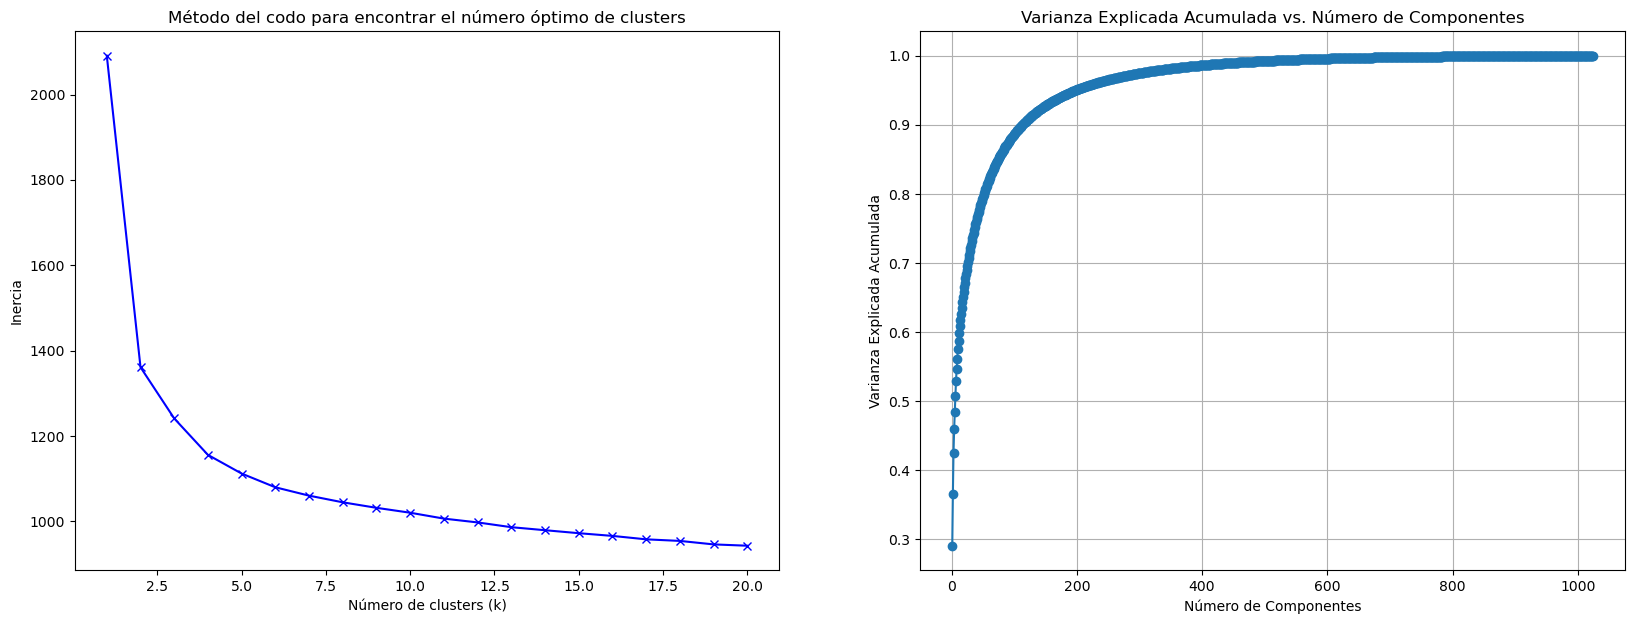

In [3]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Conectar al Blob Storage
connection_string = "*******************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "************"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings concatenados
blob_name_embeddings = "articles_embeddings_meanpooled_roberta.json"
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=blob_name_embeddings)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(filtered_embeddings_array)

# Ajustar PCA y calcular la varianza explicada
pca = PCA().fit(normalized_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Aplicar K-means con diferentes valores de n_clusters para el método del codo
inertia = []
K = range(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(filtered_embeddings_array)
    inertia.append(kmeans.inertia_)

# Crear una figura con dos gráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Graficar el método del codo
ax1.plot(K, inertia, 'bx-')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del codo para encontrar el número óptimo de clusters')

# Graficar la varianza explicada acumulada
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Explicada Acumulada')
ax2.set_title('Varianza Explicada Acumulada vs. Número de Componentes')
ax2.grid(True)

plt.show()


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 31, Finished, Available)

Shape of embeddings: (2067, 1024)
Silhouette Score: 0.09745711204484209
Number of clusters found: 4
KMeans Clustering results uploaded to articles_embeddings_meanpooled_kmeans_roberta.json


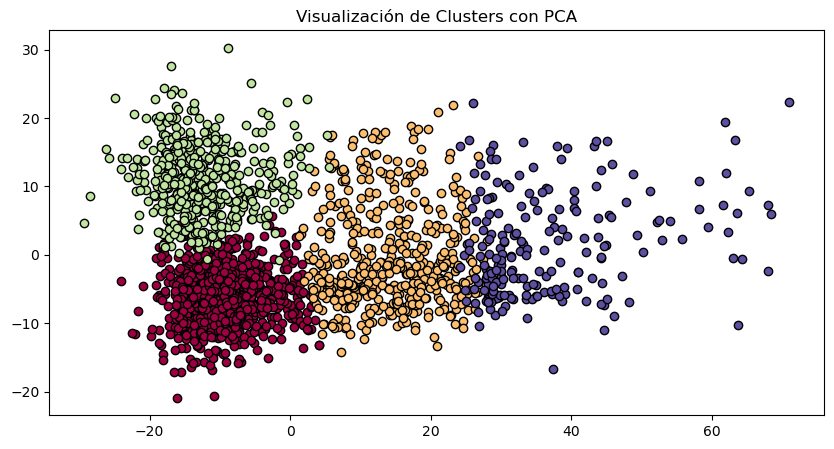

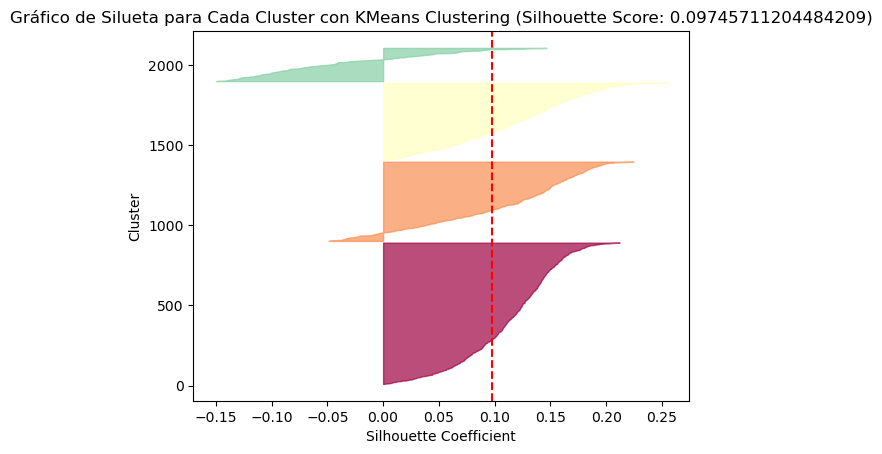

In [4]:
import json
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# KMEANS roberta-large

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("************")
container_name = "************"
input_blob_name = "articles_embeddings_meanpooled_roberta.json"
clustering_output_blob_name = "articles_embeddings_meanpooled_kmeans_roberta.json"
input_blob_client = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
clustering_output_blob_client = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)

# Descargar el archivo JSON
downloaded_blob = input_blob_client.download_blob().readall()
embeddings_data = json.loads(downloaded_blob)

# Convertir los embeddings a un formato adecuado para clustering
embeddings = np.array([article['embeddings'] for article in embeddings_data], dtype=float)

# Verificar la forma de los embeddings
print(f"Shape of embeddings: {embeddings.shape}")

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

# Reducir la dimensionalidad con PCA
pca = PCA(n_components=400)  
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Aplicar KMeans Clustering
num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Evaluar el clustering usando el índice de silueta
if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings, clusters)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score: N/A (Only one cluster found)")

print(f"Number of clusters found: {len(set(clusters))}")

# Almacenar los resultados de KMeans Clustering
kmeans_clustering_results = []
for article, cluster_label in zip(embeddings_data, clusters):
    kmeans_clustering_results.append({
        'contentId': article['contentId'],
        'cluster': int(cluster_label)
    })

# Almacenar los resultados en un archivo JSON
kmeans_clustering_results_json = json.dumps(kmeans_clustering_results)
clustering_output_blob_client.upload_blob(kmeans_clustering_results_json, overwrite=True)
print(f"KMeans Clustering results uploaded to {clustering_output_blob_name}")

# Visualizar los resultados usando PCA
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(reduced_embeddings)

# Graficar los clusters
plt.figure(figsize=(10, 5))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusters == k)
    xy = embeddings_2d[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Visualización de Clusters con PCA')
plt.show()

# Graficar el índice de silueta para cada punto
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / num_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con KMeans Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 32, Finished, Available)

Shape of embeddings: (2067, 1024)
Silhouette Score: 0.23342131872986346
Number of clusters found (including noise): 3
HDBSCAN Clustering results uploaded to articles_embeddings_meanpooled_hdbscan_roberta.json


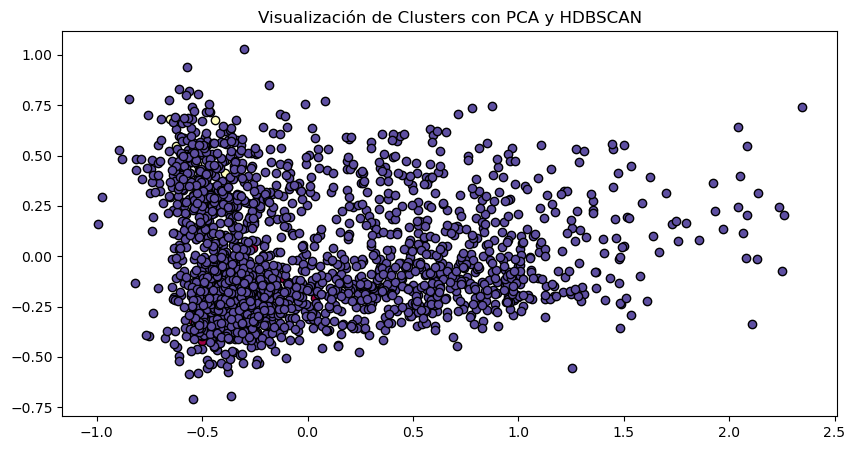

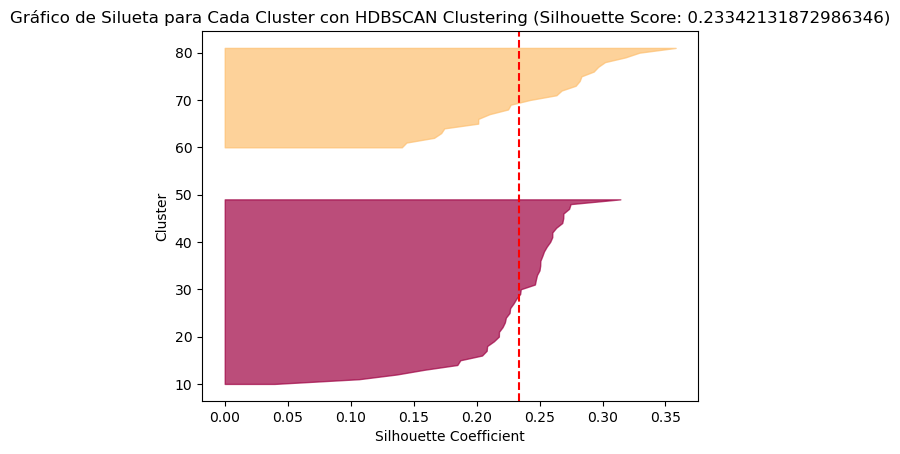

In [5]:
import json
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan

#HDBSCAN  roberta-large

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("***************")
container_name = "********"
input_blob_name = "articles_embeddings_meanpooled_roberta.json"
clustering_output_blob_name = "articles_embeddings_meanpooled_hdbscan_roberta.json"
input_blob_client = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
clustering_output_blob_client = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)

# Descargar el archivo JSON
downloaded_blob = input_blob_client.download_blob().readall()
embeddings_data = json.loads(downloaded_blob)

# Convertir los embeddings a un formato adecuado para clustering
embeddings = np.array([article['embeddings'] for article in embeddings_data], dtype=float)

# Verificar la forma de los embeddings
print(f"Shape of embeddings: {embeddings.shape}")

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Aplicar HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusters = clusterer.fit_predict(reduced_embeddings)

# Evaluar el clustering usando el índice de silueta, excluyendo el ruido (clusters == -1)
if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings[clusters != -1], clusters[clusters != -1])
    sample_silhouette_values = silhouette_samples(reduced_embeddings[clusters != -1], clusters[clusters != -1])
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score: N/A (Only one cluster found or all points are noise)")

print(f"Number of clusters found (including noise): {len(set(clusters))}")

# Almacenar los resultados de HDBSCAN Clustering
hdbscan_clustering_results = []
for article, cluster_label in zip(embeddings_data, clusters):
    hdbscan_clustering_results.append({
        'contentId': article['contentId'],
        'cluster': int(cluster_label)
    })

# Almacenar los resultados en un archivo JSON
hdbscan_clustering_results_json = json.dumps(hdbscan_clustering_results)
clustering_output_blob_client.upload_blob(hdbscan_clustering_results_json, overwrite=True)
print(f"HDBSCAN Clustering results uploaded to {clustering_output_blob_name}")

# Visualizar los resultados usando PCA para 2D
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(reduced_embeddings)

# Graficar los clusters
plt.figure(figsize=(10, 5))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusters == k)
    xy = embeddings_2d[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Visualización de Clusters con PCA y HDBSCAN')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(clusters)) - 1):  # Excluimos el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[clusters[clusters != -1] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(clusters)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  
    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 33, Finished, Available)

2024-06-22 17:08:25.561853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/nfs4/pyenv-de09b3f8-c573-41dc-ac0e-8e3bff4e46a1/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/nfs4/pyenv-de09b3f8-c573-41dc-ac0e-8e3bff4e46a1/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Downloaded 2067 embeddings.
Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Number of clusters: 16
Silhouette Score: 0.08787383884191513


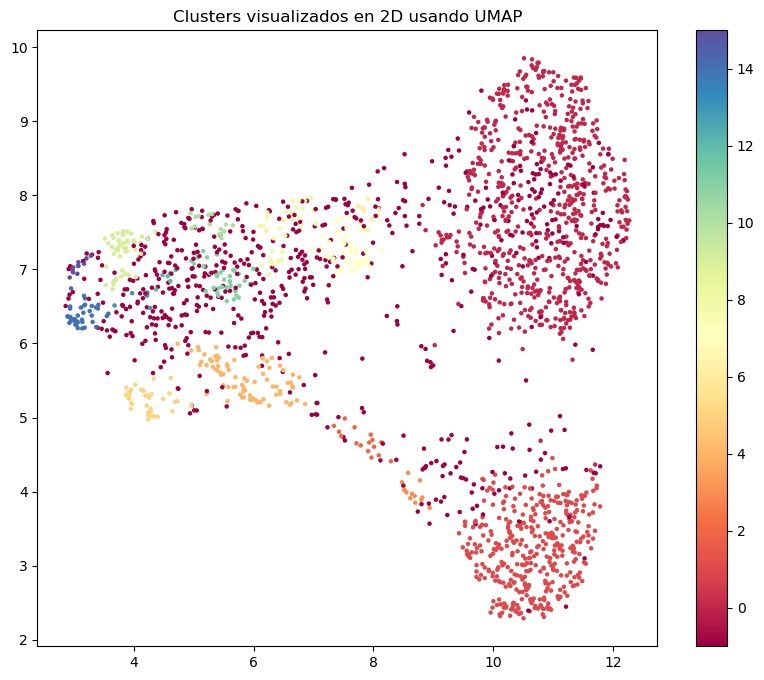

Clusters guardados en cluster_embeddings_meanpooled_umap_hdbscan_roberta.json en el contenedor newsdata.


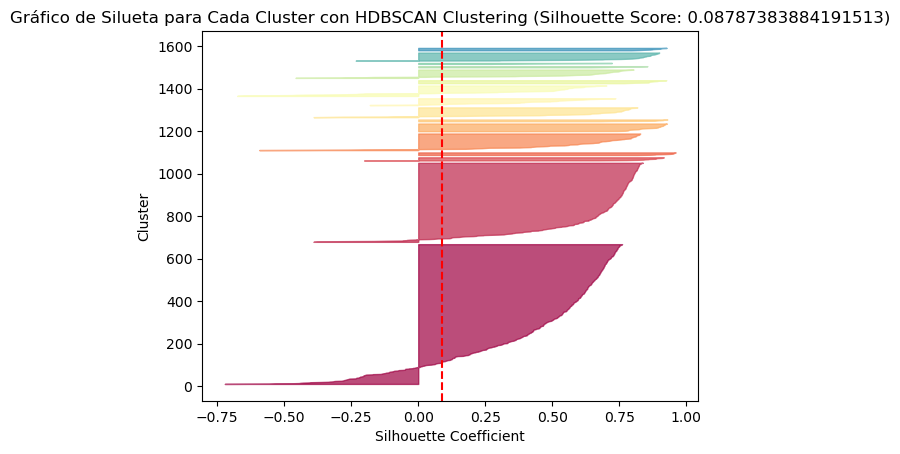

In [6]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from umap import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

#UMAP + HDBSCAN roberta-large

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("********************************")
container_name = "**********"
embeddings_blob_name = "articles_embeddings_meanpooled_roberta.json"
output_clusters_blob_name = "cluster_embeddings_meanpooled_umap_hdbscan_roberta.json"

# Descargar el archivo JSON de embeddings
embeddings_blob_client = blob_service_client.get_blob_client(container=container_name, blob=embeddings_blob_name)
try:
    downloaded_blob = embeddings_blob_client.download_blob().readall()
    embeddings_data = json.loads(downloaded_blob)
    print(f"Downloaded {len(embeddings_data)} embeddings.")
except Exception as e:
    print(f"Error al descargar el archivo JSON de embeddings: {e}")
    raise

# Extraer los embeddings y los contentIds
content_ids = [item['contentId'] for item in embeddings_data]
embeddings = [item['embeddings'] for item in embeddings_data]

# Convertir a array de numpy
embeddings_array = np.array(embeddings, dtype=np.float32)

# Normalizar los embeddings con L2
embeddings_array /= np.linalg.norm(embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con UMAP usando métrica de coseno
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings_array)

# Realizar el clustering con HDBSCAN 
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5, metric='euclidean')
clusters = hdbscan_model.fit_predict(umap_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels)) - 1}")  # Restamos 1 para el cluster -1 (ruido)

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(umap_embeddings, labels, metric='cosine')
    sample_silhouette_values = silhouette_samples(umap_embeddings, labels, metric='cosine')
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D
umap_2d = UMAP(n_components=2, random_state=42, metric='cosine')
umap_2d_embeddings = umap_2d.fit_transform(embeddings_array)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d_embeddings[:, 0], umap_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando UMAP')
plt.show()

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster y el texto
clustered_texts = []
for content_id, label in zip(content_ids, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("cluster_umap_hdbscan_roberta.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
clusters_blob_client = blob_service_client.get_blob_client(container=container_name, blob=output_clusters_blob_name)
try:
    with open("cluster_umap_hdbscan_roberta.json", "rb") as data:
        clusters_blob_client.upload_blob(data, overwrite=True)
    print(f"Clusters guardados en {output_clusters_blob_name} en el contenedor {container_name}.")
except Exception as e:
    print(f"Error al subir los clusters al Blob Storage: {e}")
    raise

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10 

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 34, Finished, Available)

Number of texts after filtering: 2067
Number of embeddings after filtering: 2067
Max embedding length: 1024


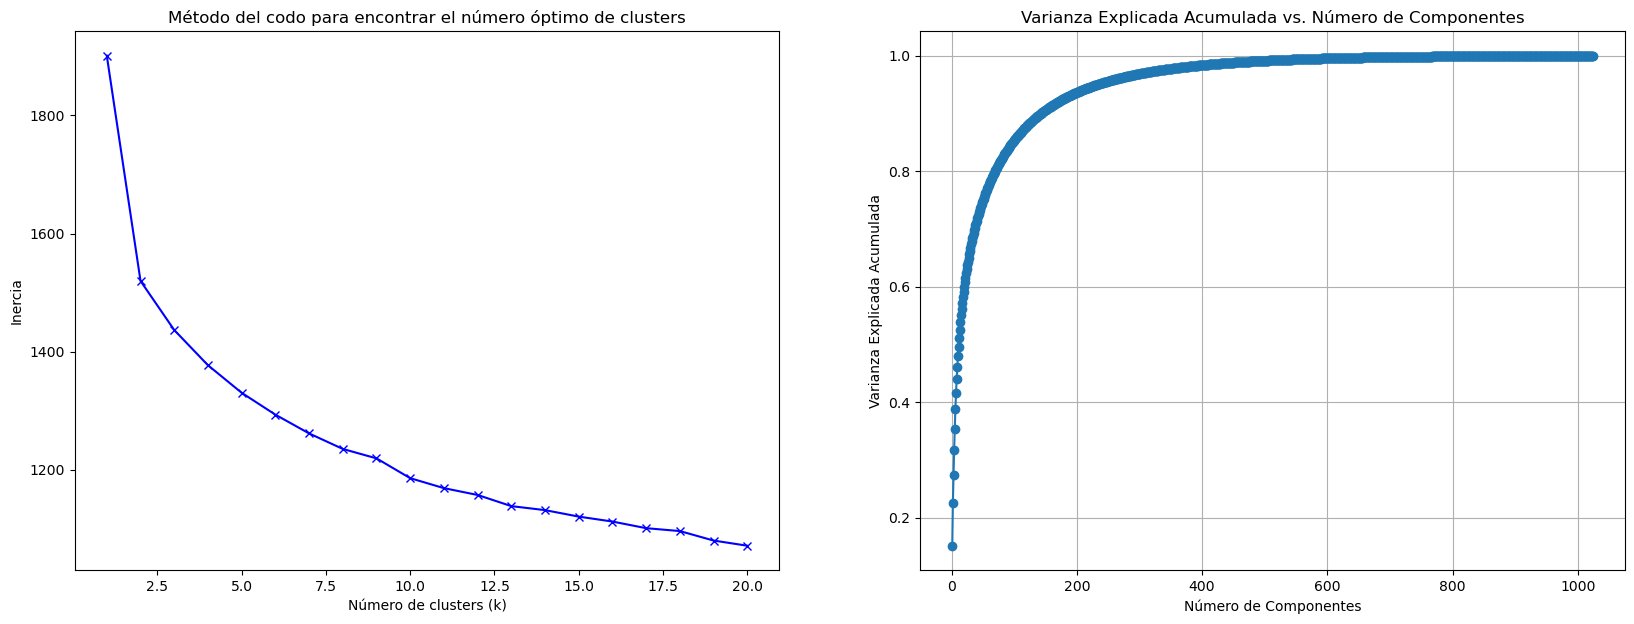

In [7]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Conectar al Blob Storage
connection_string = "*******************"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_name = "**********"

# Descargar el archivo de textos
blob_name_articles = "articles.json"
blob_client_articles = blob_service_client.get_blob_client(container=container_name, blob=blob_name_articles)
downloaded_blob_articles = blob_client_articles.download_blob().readall()
articles_data = json.loads(downloaded_blob_articles)

# Descargar el archivo de embeddings concatenados
blob_name_embeddings = "articles_embeddings_meanpooled_roberta_CA.json"
blob_client_embeddings = blob_service_client.get_blob_client(container=container_name, blob=blob_name_embeddings)
downloaded_blob_embeddings = blob_client_embeddings.download_blob().readall()
embeddings_data = json.loads(downloaded_blob_embeddings)

# Crear diccionarios para acceder rápidamente a textos y embeddings por contentId
articles_dict = {article['contentId']: article['text'] for article in articles_data}
embeddings_dict = {embedding['contentId']: embedding['embeddings'] for embedding in embeddings_data}

# Filtrar los contentIds que están presentes en ambos diccionarios
common_content_ids = set(articles_dict.keys()).intersection(set(embeddings_dict.keys()))

# Obtener los textos y embeddings correspondientes a los contentIds comunes
filtered_texts = [articles_dict[content_id] for content_id in common_content_ids]
filtered_embeddings = [embeddings_dict[content_id] for content_id in common_content_ids]

# Verificar la longitud después de filtrar
print(f"Number of texts after filtering: {len(filtered_texts)}")
print(f"Number of embeddings after filtering: {len(filtered_embeddings)}")

# Encontrar la longitud máxima de los embeddings
max_length = max(len(embedding) for embedding in filtered_embeddings)
print(f"Max embedding length: {max_length}")

# Rellenar los embeddings para que todos tengan la misma longitud
def pad_embedding(embedding, target_length):
    return embedding + [0.0] * (target_length - len(embedding))

padded_embeddings = [pad_embedding(embedding, max_length) for embedding in filtered_embeddings]

# Convertir a array de numpy
filtered_embeddings_array = np.array(padded_embeddings, dtype=np.float32)

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(filtered_embeddings_array)

# Ajustar PCA y calcular la varianza explicada
pca = PCA().fit(normalized_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Aplicar K-means con diferentes valores de n_clusters para el método del codo
inertia = []
K = range(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(filtered_embeddings_array)
    inertia.append(kmeans.inertia_)

# Crear una figura con dos gráficos uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Graficar el método del codo
ax1.plot(K, inertia, 'bx-')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del codo para encontrar el número óptimo de clusters')

# Graficar la varianza explicada acumulada
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Explicada Acumulada')
ax2.set_title('Varianza Explicada Acumulada vs. Número de Componentes')
ax2.grid(True)

plt.show()


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 35, Finished, Available)

Shape of embeddings: (2067, 1024)
Silhouette Score: 0.045927376397731125
Number of clusters found: 4
KMeans Clustering results uploaded to articles_embeddings_meanpooled_kmeans_roberta_CA.json


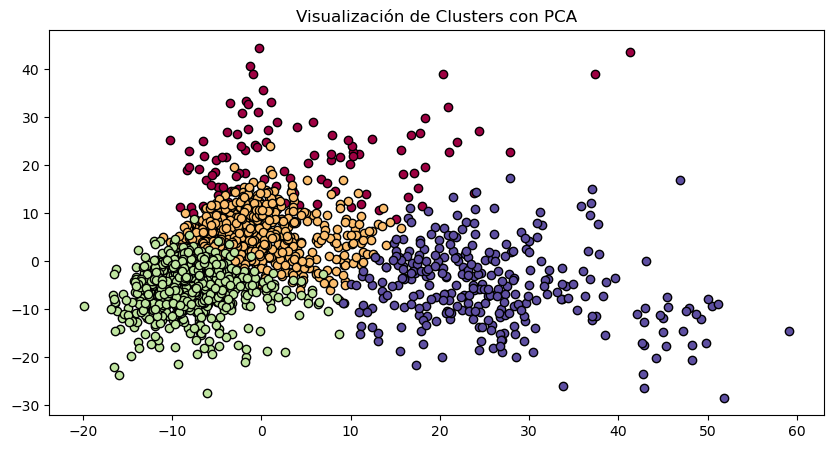

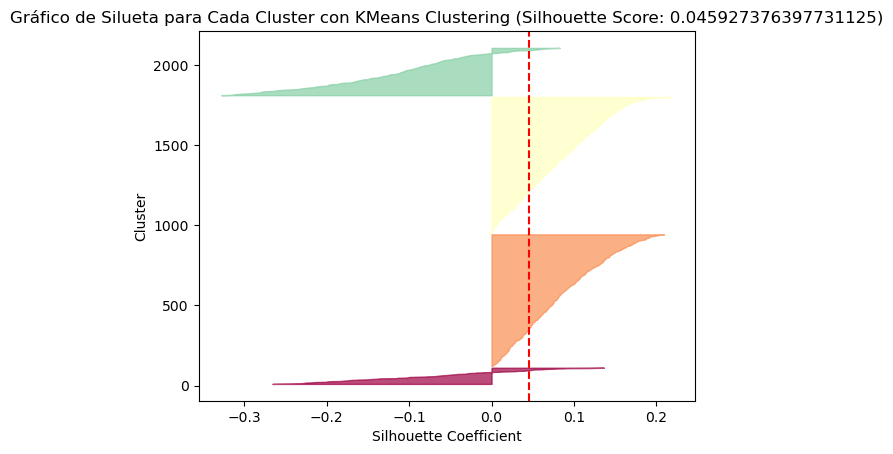

In [8]:
import json
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#KMEANS  roberta-large-ca-v2

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("***********************")
container_name = "**********"
input_blob_name = "articles_embeddings_meanpooled_roberta_CA.json"
clustering_output_blob_name = "articles_embeddings_meanpooled_kmeans_roberta_CA.json"
input_blob_client = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
clustering_output_blob_client = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)

# Descargar el archivo JSON
downloaded_blob = input_blob_client.download_blob().readall()
embeddings_data = json.loads(downloaded_blob)

# Convertir los embeddings a un formato adecuado para clustering
embeddings = np.array([article['embeddings'] for article in embeddings_data], dtype=float)

# Verificar la forma de los embeddings
print(f"Shape of embeddings: {embeddings.shape}")

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

# Reducir la dimensionalidad con PCA
pca = PCA(n_components=400)  
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Aplicar KMeans Clustering
num_clusters = 4  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Evaluar el clustering usando el índice de silueta
if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings, clusters)
    sample_silhouette_values = silhouette_samples(reduced_embeddings, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score: N/A (Only one cluster found)")

print(f"Number of clusters found: {len(set(clusters))}")

# Almacenar los resultados de KMeans Clustering
kmeans_clustering_results = []
for article, cluster_label in zip(embeddings_data, clusters):
    kmeans_clustering_results.append({
        'contentId': article['contentId'],
        'cluster': int(cluster_label)
    })

# Almacenar los resultados en un archivo JSON
kmeans_clustering_results_json = json.dumps(kmeans_clustering_results)
clustering_output_blob_client.upload_blob(kmeans_clustering_results_json, overwrite=True)
print(f"KMeans Clustering results uploaded to {clustering_output_blob_name}")

# Visualizar los resultados usando PCA
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(reduced_embeddings)

# Graficar los clusters
plt.figure(figsize=(10, 5))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusters == k)
    xy = embeddings_2d[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Visualización de Clusters con PCA')
plt.show()

# Graficar el índice de silueta para cada punto
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / num_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  

    plt.title(f"Gráfico de Silueta para Cada Cluster con KMeans Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 36, Finished, Available)

Shape of embeddings: (2067, 1024)
Silhouette Score: N/A (Only one cluster found or all points are noise)
Number of clusters found (including noise): 1
HDBSCAN Clustering results uploaded to articles_embeddings_meanpooled_hdbscan_roberta_CA.json


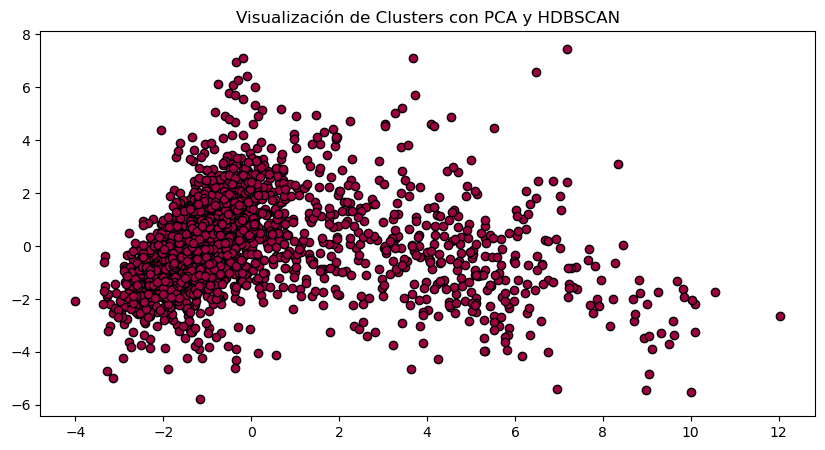

No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.


In [9]:
import json
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan

#HDBSCAN   roberta-large-ca-v2

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("***********************")
container_name = "*********"
input_blob_name = "articles_embeddings_meanpooled_roberta_CA.json"
clustering_output_blob_name = "articles_embeddings_meanpooled_hdbscan_roberta_CA.json"
input_blob_client = blob_service_client.get_blob_client(container=container_name, blob=input_blob_name)
clustering_output_blob_client = blob_service_client.get_blob_client(container=container_name, blob=clustering_output_blob_name)

# Descargar el archivo JSON
downloaded_blob = input_blob_client.download_blob().readall()
embeddings_data = json.loads(downloaded_blob)

# Convertir los embeddings a un formato adecuado para clustering
embeddings = np.array([article['embeddings'] for article in embeddings_data], dtype=float)

# Verificar la forma de los embeddings
print(f"Shape of embeddings: {embeddings.shape}")

# Normalizar los embeddings
scaler = StandardScaler()
normalized_embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

# Reducir la dimensionalidad con PCA
n_components = 400  # Ajustado valor basado en análisis previo
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# Aplicar HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusters = clusterer.fit_predict(reduced_embeddings)

# Evaluar el clustering usando el índice de silueta, excluyendo el ruido (clusters == -1)
if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings[clusters != -1], clusters[clusters != -1])
    sample_silhouette_values = silhouette_samples(reduced_embeddings[clusters != -1], clusters[clusters != -1])
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score: N/A (Only one cluster found or all points are noise)")

print(f"Number of clusters found (including noise): {len(set(clusters))}")

# Almacenar los resultados de HDBSCAN Clustering
hdbscan_clustering_results = []
for article, cluster_label in zip(embeddings_data, clusters):
    hdbscan_clustering_results.append({
        'contentId': article['contentId'],
        'cluster': int(cluster_label)
    })

# Almacenar los resultados en un archivo JSON
hdbscan_clustering_results_json = json.dumps(hdbscan_clustering_results)
clustering_output_blob_client.upload_blob(hdbscan_clustering_results_json, overwrite=True)
print(f"HDBSCAN Clustering results uploaded to {clustering_output_blob_name}")

# Visualizar los resultados usando PCA para 2D
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(reduced_embeddings)

# Graficar los clusters
plt.figure(figsize=(10, 5))
unique_labels = set(clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (clusters == k)
    xy = embeddings_2d[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Visualización de Clusters con PCA y HDBSCAN')
plt.show()

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(clusters)) - 1):  # Excluimos el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[clusters[clusters != -1] == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(clusters)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")


StatementMeta(e4f89f09-5ae4-4fe6-ba6c-d749a8fdfc99, 40, 37, Finished, Available)

Downloaded 2067 embeddings.
Cluster labels: [0 1]
Number of clusters: 1
Silhouette Score: 0.5927439332008362


/nfs4/pyenv-de09b3f8-c573-41dc-ac0e-8e3bff4e46a1/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/nfs4/pyenv-de09b3f8-c573-41dc-ac0e-8e3bff4e46a1/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


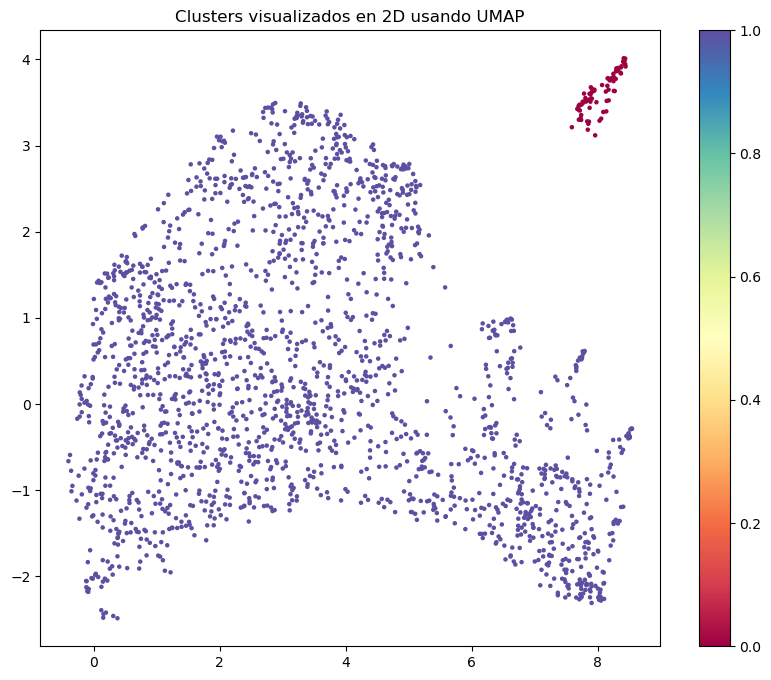

Clusters guardados en cluster_embeddings_meanpooled_umap_hdbscan_roberta_CA.json en el contenedor newsdata.


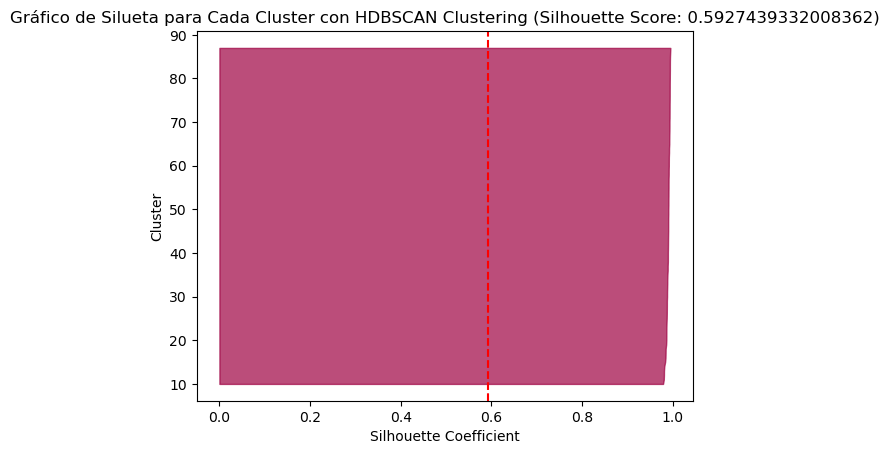

In [10]:
import json
import numpy as np
from azure.storage.blob import BlobServiceClient
from umap import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

#UMAP + HDBSCAN  roberta-large-ca-v2

# Conectar al Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("**************************")
container_name = "*******"
embeddings_blob_name = "articles_embeddings_meanpooled_roberta_CA.json"
output_clusters_blob_name = "cluster_embeddings_meanpooled_umap_hdbscan_roberta_CA.json"

# Descargar el archivo JSON de embeddings
embeddings_blob_client = blob_service_client.get_blob_client(container=container_name, blob=embeddings_blob_name)
try:
    downloaded_blob = embeddings_blob_client.download_blob().readall()
    embeddings_data = json.loads(downloaded_blob)
    print(f"Downloaded {len(embeddings_data)} embeddings.")
except Exception as e:
    print(f"Error al descargar el archivo JSON de embeddings: {e}")
    raise

# Extraer los embeddings y los contentIds
content_ids = [item['contentId'] for item in embeddings_data]
embeddings = [item['embeddings'] for item in embeddings_data]

# Convertir a array de numpy
embeddings_array = np.array(embeddings, dtype=np.float32)

# Normalizar los embeddings con L2
embeddings_array /= np.linalg.norm(embeddings_array, axis=1, keepdims=True)

# Reducir la dimensionalidad con UMAP usando métrica de coseno
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings_array)

# Realizar el clustering con HDBSCAN 
hdbscan_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5, metric='euclidean')
clusters = hdbscan_model.fit_predict(umap_embeddings)

# Obtener las etiquetas de los clusters
labels = hdbscan_model.labels_

# Mostrar la distribución de los clusters
print(f"Cluster labels: {np.unique(labels)}")
print(f"Number of clusters: {len(np.unique(labels)) - 1}")  # Restamos 1 para el cluster -1 (ruido)

# Calcular el índice de Silhouette
if len(set(labels)) > 1:  # Silhouette score no está definido para un solo cluster
    silhouette_avg = silhouette_score(umap_embeddings, labels, metric='cosine')
    sample_silhouette_values = silhouette_samples(umap_embeddings, labels, metric='cosine')
    print(f"Silhouette Score: {silhouette_avg}")
else:
    silhouette_avg = -1
    sample_silhouette_values = None
    print("Silhouette Score no está definido para un solo cluster.")

# Visualización de los clusters en 2D
umap_2d = UMAP(n_components=2, random_state=42, metric='cosine')
umap_2d_embeddings = umap_2d.fit_transform(embeddings_array)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d_embeddings[:, 0], umap_2d_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('Clusters visualizados en 2D usando UMAP')
plt.show()

# Crear una lista con los resultados de los clusters incluyendo el ID del cluster y el texto
clustered_texts = []
for content_id, label in zip(content_ids, labels):
    clustered_texts.append({"idCluster": int(label), "contentId": content_id})

# Guardar los clusters en un archivo JSON
clusters_data = json.dumps(clustered_texts, ensure_ascii=False, indent=4)
with open("cluster_umap_hdbscan_roberta.json", "w", encoding="utf-8") as f:
    f.write(clusters_data)

# Subir el archivo JSON al Blob Storage
clusters_blob_client = blob_service_client.get_blob_client(container=container_name, blob=output_clusters_blob_name)
try:
    with open("cluster_umap_hdbscan_roberta.json", "rb") as data:
        clusters_blob_client.upload_blob(data, overwrite=True)
    print(f"Clusters guardados en {output_clusters_blob_name} en el contenedor {container_name}.")
except Exception as e:
    print(f"Error al subir los clusters al Blob Storage: {e}")
    raise

# Graficar el índice de silueta para cada punto, excluyendo el ruido
if sample_silhouette_values is not None:
    plt.figure()
    y_lower = 10
    for i in range(len(set(labels)) - 1):  # Excluye el cluster de ruido (-1)
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / len(set(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Gráfico de Silueta para Cada Cluster con HDBSCAN Clustering (Silhouette Score: {silhouette_avg})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
else:
    print("No se puede generar el gráfico de silueta debido a que solo se encontró un cluster o todos los puntos son ruido.")
